In [ ]:
"""

Date : August 1, 2019

Author : Heather Landry Drexler

This script will develop plots for Supplemental Figure 4 of the nanoCOP manuscript. 
                                            

"""

In [1]:
import numpy as np
import pandas as pd
import pysam
from collections import Counter
import seaborn as sns
sns.set_style("white")

import matplotlib.pyplot as plt
import re
% matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter

import math

from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats, chi2_contingency
from scipy.special import stdtr

import pybedtools
from pybedtools import BedTool

In [2]:
def get_read_end_stats(read_ends):
    
    read_features = []

    for k, v in read_ends.items():

        if (len(v) == 1):
            read_features.append([k,v[0]])

        if (len(v) > 1):
            if ("polyA" in v):
                read_features.append([k,"polyA"])

            elif ("post_polyA" in v):
                read_features.append([k,"post_polyA"])

            elif ("intron_SS" in v):
                read_features.append([k,"splice_site"])

            elif ("RNAPET" in v):
                read_features.append([k,"RNAPET"])

            else:
                read_features.append([k,"undetermined"])

    read_features_df = pd.DataFrame(read_features)
    read_features_df.columns = ['read','end_feature']
    
    return read_features_df


def get_pie_chart_df(read_features_df,read_ends_bedtool):

    pie_chart = []
    pie_chart.append(['exon',len(read_features_df[read_features_df['end_feature']=='exon'])])
    pie_chart.append(['splice_site',len(read_features_df[read_features_df['end_feature']=='splice_site'])])
    pie_chart.append(['intron',len(read_features_df[read_features_df['end_feature']=='intron'])])
    pie_chart.append(['polyA',len(read_features_df[read_features_df['end_feature']=='polyA'])+len(read_features_df[read_features_df['end_feature']=='RNAPET'])])
    pie_chart.append(['post_polyA',len(read_features_df[read_features_df['end_feature']=='post_polyA'])])
    #pie_chart.append(['RNAPET',len(read_features_df[read_features_df['end_feature']=='RNAPET'])])
    pie_chart.append(['other',len(read_ends_bedtool.to_dataframe())-len(read_features_df)])
    pie_chart.append(['undetermined',len(read_features_df[read_features_df['end_feature']=='undetermined'])])
    pie_chart_df = pd.DataFrame(pie_chart)
    pie_chart_df = pie_chart_df.set_index([0])
    pie_chart_df.columns = ['count']
    pie_chart_df
    
    return pie_chart_df


# function to label missing gene names with transcript names
def name_missing_genes(row):
    if pd.isnull(row['gene']):
        return (row['transcript'])

    else:
        return (row['gene'])

    
# output downsampled bed files for ONT correlation plots
def get_downsampled_bed(bamFile_A, bamFile_B):
        
    bedFile_A = bamFile_A.bam_to_bed(split=True) 
    bedFile_B = bamFile_B.bam_to_bed(split=True) 

    N = min(len(bedFile_A), len(bedFile_B))

    downsampled_bedFile_A = bedFile_A.sample(n=N)
    downsampled_bedFile_B = bedFile_B.sample(n=N)
    
    return downsampled_bedFile_A, downsampled_bedFile_B


# output downsampled bed files for ONT correlation plots
def get_replicate_coverage_df(bamFile_A, bamFile_B, genes_bed):
        
    read_bed_A, read_bed_B = get_downsampled_bed(bamFile_A, bamFile_B)

    # get number of reads that overlap each gene feature
    coverage_A = genes_bed.coverage(read_bed_A, s=True, mean=True) 
    coverage_A_df = coverage_A.to_dataframe() 
    coverage_A_df.columns =['chrom','start','end','transcript','score','strand','gene','coverage'] # label columns
    coverage_A_df = coverage_A_df[coverage_A_df['coverage']>0]

    coverage_B = genes_bed.coverage(read_bed_B, s=True, mean=True) 
    coverage_B_df = coverage_B.to_dataframe() 
    coverage_B_df.columns =['chrom','start','end','transcript','score','strand','gene','coverage'] # label columns
    coverage_B_df = coverage_B_df[coverage_B_df['coverage']>0]
    
    return coverage_A_df, coverage_B_df


# output downsampled bed files for ONT correlation plots
def get_counts_df(bamFile, genes_bed):
        
    bedFile = bamFile.bam_to_bed(split=False) 

    # get number of reads that overlap each gene feature
    counts = genes_bed.coverage(bedFile, s=True, counts=True) 
    counts_df = counts.to_dataframe() 
    counts_df.columns =['chrom','start','end','transcript','score','strand','gene','counts'] # label columns
    counts_df['counts'] = counts_df['counts'].replace(0, 0.2)
    
    return counts_df


# determine gene counts per gene for ONT reads
def get_ONT_gene_counts(gene_bed, read_bed):
        
    # get number of reads that overlap each gene feature
    coverage = gene_bed.coverage(read_bed, s=True, counts=True) 
    
    # make a dataframe from coverage file
    df = coverage.to_dataframe() # covert to dataframe
    df.columns =['chrom','start','end','transcript','score','strand','gene','count'] # label columns
    df = df.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True) # remove duplicate gene coords
    
    # get read counts per gene
    freq = df['count'].value_counts() 

    return freq


# Analyze reads ends to make sure they map to the end of the ERCC transcript (to exclude the possibility of internal
# polyadenylation)

def get_read_end_bedtool(bamFile):

    bedFile = bamFile.bam_to_bed()
    bedFile_df = bedFile.to_dataframe()
        
    read_end = []
        
    for i in range(0,len(bedFile_df)):

        chrom = str(bedFile_df['chrom'].iloc[i])
        start = bedFile_df['start'].iloc[i]
        end = bedFile_df['end'].iloc[i]
        read = bedFile_df['name'].iloc[i]
        score = bedFile_df['score'].iloc[i]
        strand = bedFile_df['strand'].iloc[i]

        if (strand == "-"):
            pos_1 = start
            pos_2 = start + 1

        if (strand == "+"):
            pos_1 = end - 1
            pos_2 = end

        read_end.append([chrom,str(pos_1),str(pos_2),read,str(score),strand])

    read_end_bedtool = BedTool(read_end)
    return read_end_bedtool


# function for getting all 3' end positions of reads around a single ERCC transcript's "polyA" site
def get_single_ERCC_read_ends(transcript_name, transcript_end_pos, read_ends_df):
    
    end_pos = transcript_end_pos
    
    all_values = []
    
    for i in range(len(read_ends_df)):
        read_name = read_ends_df.loc[i]['name']
        read_end = read_ends_df.loc[i]['end']
        read_strand = read_ends_df.loc[i]['strand']
        
        if read_strand == "+" and abs(read_end - end_pos) < 1000:
            dif = read_end - end_pos
            all_values.append(dif)
    
    all_values.append(-1000)
    all_values.append(1000)
    return all_values


def get_intron_5SS(annotation_df, window):

    # make a set for all 3'SS coordinates
    splice_site = []

    # loop through a file with intron coordinates
    # check if feature is an intron
    for i in range(0,len(annotation_df)):
        feature = annotation_df['feature'].iloc[i].split("_")[0]    # feature
 
        if (feature == 'intron'):
            chrom = annotation_df['chrom'].iloc[i]                  # chromosome
            intron_start = int(annotation_df['start'].iloc[i])      # start coordinate of intron (last base of exon)
            intron_end = int(annotation_df['end'].iloc[i])          # end coordinate of intron (last base of intron)
            gene = annotation_df['gene'].iloc[i]                    # gene name
            strand = annotation_df['strand'].iloc[i]                # strand of gene with intron
            count = annotation_df['feature'].iloc[i].split("_")[1]  # feature count
            name = annotation_df['feature'].iloc[i]                 # get feature and count for output file

            # get 5' SS positions for introns on each strand
            if strand=='+':
                ss = int(intron_start)
            if strand=='-':
                ss = int(intron_end)
            
            # set boundaries around the splice sites for analysis
            ss_start = ss-window
            ss_end = ss+window
   
            splice_site.append([chrom,ss_start,ss_end,gene,name,strand])
    
    bedtool_5SS = BedTool(splice_site)
    return bedtool_5SS

def get_intron_3SS(annotation_df, window):

    # make a set for all 3'SS coordinates
    splice_site = []

    # loop through a file with intron coordinates
    # check if feature is an intron
    for i in range(0,len(annotation_df)):
        feature = annotation_df['feature'].iloc[i].split("_")[0]    # feature
 
        if (feature == 'intron'):
            chrom = annotation_df['chrom'].iloc[i]                  # chromosome
            intron_start = int(annotation_df['start'].iloc[i])      # start coordinate of intron (last base of exon)
            intron_end = int(annotation_df['end'].iloc[i])          # end coordinate of intron (last base of intron)
            gene = annotation_df['gene'].iloc[i]                    # gene name
            strand = annotation_df['strand'].iloc[i]                # strand of gene with intron
            count = annotation_df['feature'].iloc[i].split("_")[1]  # feature count
            name = annotation_df['feature'].iloc[i]                 # get feature and count for output file

            # get 3' SS positions for introns on each strand
            if strand=='+':
                ss = int(intron_end)
            if strand=='-':
                ss = int(intron_start)
            
            # set boundaries around the splice sites for analysis
            ss_start = ss-window
            ss_end = ss+window
   
            splice_site.append([chrom,ss_start,ss_end,gene,name,strand])
    
    bedtool_3SS = BedTool(splice_site)
    return bedtool_3SS


def get_intron_middle(annotation_df, window):

    # make a set for all 3'SS coordinates
    splice_site = []

    # loop through a file with intron coordinates
    # check if feature is an intron
    for i in range(0,len(annotation_df)):
        feature = annotation_df['feature'].iloc[i].split("_")[0]    # feature
 
        if (feature == 'intron'):
            chrom = annotation_df['chrom'].iloc[i]                  # chromosome
            intron_start = int(annotation_df['start'].iloc[i])      # start coordinate of intron (last base of exon)
            intron_end = int(annotation_df['end'].iloc[i])          # end coordinate of intron (last base of intron)
            gene = annotation_df['gene'].iloc[i]                    # gene name
            strand = annotation_df['strand'].iloc[i]                # strand of gene with intron
            count = annotation_df['feature'].iloc[i].split("_")[1]  # feature count
            name = annotation_df['feature'].iloc[i]                 # get feature and count for output file

            # get the middle position of introns
            middle = (int(intron_end)+int(intron_start))/2
            
            # set boundaries around the splice sites for analysis
            middle_start = middle-window
            middle_end = middle+window
   
            splice_site.append([chrom,middle_start,middle_end,gene,name,strand])
    
    bedtool_middle = BedTool(splice_site)
    return bedtool_middle


def get_intron_info(annotation_df, window):

    # make a set for all 3'SS coordinates
    splice_site = []

    # loop through a file with intron coordinates
    # check if feature is an intron
    for i in range(0,len(annotation_df)):
        feature = annotation_df['feature'].iloc[i].split("_")[0]    # feature
 
        if (feature == 'intron'):
            chrom = annotation_df['chrom'].iloc[i]                  # chromosome
            intron_start = int(annotation_df['start'].iloc[i])      # start coordinate of intron (last base of exon)
            intron_end = int(annotation_df['end'].iloc[i])          # end coordinate of intron (last base of intron)
            gene = annotation_df['gene'].iloc[i]                    # gene name
            strand = annotation_df['strand'].iloc[i]                # strand of gene with intron
            count = annotation_df['feature'].iloc[i].split("_")[1]  # feature count
            name = annotation_df['feature'].iloc[i]                 # get feature and count for output file

            # get the middle position of introns
            middle = int((intron_end+intron_start)/2)
            
            # set boundaries around the intron middle for analysis
            # add info to intron splice site list
            middle_start = middle-window
            middle_end = middle+window
            splice_site.append([str(chrom),str(middle_start),str(middle_end),str(gene),'intron_middle',str(strand)])

            # get 3' SS positions for introns on each strand
            if strand=='+':
                intron_5SS = int(intron_start)
                intron_3SS = int(intron_end)
            
            if strand=='-':
                intron_5SS = int(intron_end)
                intron_3SS = int(intron_start)

            # set boundaries around the 5SS for analysis
            # add info to intron splice site list
            intron_5SS_start = intron_5SS-window
            intron_5SS_end = intron_5SS+window
            splice_site.append([str(chrom),str(intron_5SS_start),str(intron_5SS_end),str(gene),'intron_5SS',str(strand)])

            # set boundaries around the 5SS for analysis
            # add info to intron splice site list
            intron_3SS_start = intron_3SS-window
            intron_3SS_end = intron_3SS+window
            splice_site.append([str(chrom),str(intron_3SS_start),str(intron_3SS_end),str(gene),'intron_3SS',str(strand)])

    bedtool_intron_info = BedTool(splice_site)
    return bedtool_intron_info
    
    
def get_intersect_df(bamFile, intron_info):

    bedFile = bamFile.bam_to_bed(cigar=True, tag='NM') # convert bam file to bed file, keep cigar string and NM (edit distance) tag
    intersect = bedFile.intersect(intron_info, wo=True, s=True) # intersect reads from bam file with 3' splice site coordinates, ensure strandedness
    intersect_df = intersect.to_dataframe(names=['chrom_read', 'start_read', 'end_read', 'name_read', 'qual_read', \
                                           'strand_read', 'cigar_read', 'chr_feature', 'start_feature', \
                                           'end_feature', 'name_gene', 'name_feature', 'strand_feature', 'count'], \
                               dtype={"chrom_read": str, "start_read": int, "end_read": int, \
                                     "name_read": str, "qual_read": int, "strand_read": str, "cigar_read": str, \
                                    "chr_feature": str, "start_feature": int, "end_feature": int, "name_gene": str, \
                                     "name_feature": str,"strand_feature": str, "count": int}) # convert to a dataframe

    return intersect_df


def get_distance_df(intersect_df):

    # prepare a list for distance between read end and 5SS
    dist = []
    
    # set variables for parsing the cigar string
    pattern = re.compile('([MIDNSHPX=])')
    Consumes_Query = ["M", "I", "S", "=", "X"]
    Consumes_Reference = ["M", "D", "N", "=", "X"]    
    
    for i in range(0,intersect_df.shape[0]):

        chrom = intersect_df.chrom_read.iloc[i]
        strand = intersect_df.strand_feature.iloc[i]
        name_read = intersect_df['name_read'].iloc[i]
        name_feature = intersect_df['name_feature'].iloc[i]
        ss = (intersect_df.start_feature.iloc[i] + intersect_df.end_feature.iloc[i])/2    # record 5' splice site position

        # parse cigar string into a list of tuples for easy parsing
        Sep_Values = pattern.split(intersect_df.cigar_read[i])[:-1]
        CigarPairs = list((Sep_Values[n:n+2] for n in range(0, len(Sep_Values), 2)))  

        if strand == "-":
            align_3p_end = intersect_df.start_read.iloc[i]    # record 3' end of read
            align_5p_end = intersect_df.end_read.iloc[i]      # record 5' end of read
            dist_3p = ss-align_3p_end                         # record distance between read end and splice site
            dist_5p = ss-align_5p_end                         # record distance between read start and splice site
            
            # get RNA start softclip length
            last=len(CigarPairs)
            if(CigarPairs[last-1][1]=='S'):
                start_clip=CigarPairs[last-1][0]
            elif(CigarPairs[last-1][1]=='H'):
                start_clip=CigarPairs[last-1][0]
            elif(CigarPairs[last-1][1]!='S' or CigarPairs[last-1][1]!='H'):
                start_clip=0
                
            # get RNA end softclip length
            if(CigarPairs[0][1]=='S'):
                end_clip=CigarPairs[0][0]
            elif(CigarPairs[0][1]=='H'):
                end_clip=CigarPairs[0][0]
            elif(CigarPairs[0][1]!='S' or CigarPairs[0][1]!='H'):
                end_clip=0

                
        if strand == "+":
            align_3p_end = intersect_df.end_read.iloc[i]      # record 3' end of read
            align_5p_end = intersect_df.start_read.iloc[i]    # record 5' end of read
            dist_3p = align_3p_end-ss                         # record distance between read end and splice site
            dist_5p = align_5p_end-ss                         # record distance between read start and splice site
            
            # get RNA start softclip length
            if(CigarPairs[0][1]=='S'):
                start_clip=CigarPairs[0][0]
            elif(CigarPairs[0][1]=='H'):
                start_clip=CigarPairs[0][0]
            elif(CigarPairs[0][1]!='S' or CigarPairs[0][1]!='H'):
                start_clip=0

            # get RNA end softclip length
            last=len(CigarPairs)
            if(CigarPairs[last-1][1]=='S'):
                end_clip=CigarPairs[last-1][0]
            elif(CigarPairs[last-1][1]=='H'):
                end_clip=CigarPairs[last-1][0]
            elif(CigarPairs[last-1][1]!='S' or CigarPairs[last-1][1]!='H'):
                end_clip=0
                
                
        if (dist_5p >= -100 and dist_5p <= 100 and int(start_clip) <= 10 and int(end_clip) <= 75):
            dist.append([name_read,chrom,ss,strand,name_feature,'read_start',dist_5p,start_clip,end_clip])

        if (dist_3p >= -100 and dist_3p <= 100 and int(start_clip) <= 10 and int(end_clip) <= 75):
            dist.append([name_read,chrom,ss,strand,name_feature,'read_end',dist_3p,start_clip,end_clip])

    distance_df = pd.DataFrame(dist)
    distance_df.columns = ['read_name','chrom','position','strand','feature_name','read_pos','distance','start_clip','end_clip']
    distance_df = distance_df.drop_duplicates().reset_index(drop=True)
    
    return distance_df


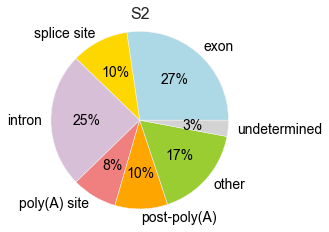

In [21]:
# SUPPLEMENTAL FIGURE S4A - S2 (with polyA polymerase) pie chart
# This script takes as input the files made in the script nanoCOP_pie_chart_datasets.ipynb

# read in files for making read end pie charts
S2_read_ends_df = pd.read_table('/path/to/S2_read_ends.txt')  
S2_read_ends = pybedtools.BedTool.from_dataframe(S2_read_ends_df)
S2_read_ends = S2_read_ends.saveas()
S2_read_ends_stats = pd.read_table('/path/to/S2_read_end_stats.txt')  

# make dataframe for pie chart
S2_pie_chart_df = get_pie_chart_df(S2_read_ends_stats, S2_read_ends)

fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(3.5,3.5))

col_list = ['lightblue', 'gold', 'thistle', 'lightcoral', 'orange', 'yellowgreen', 'lightgray']
label_list=['exon','splice site','intron','poly(A) site','post-poly(A)','other','undetermined']

wedges, texts, autotexts = ax.pie(S2_pie_chart_df, labels=label_list, colors=col_list, autopct='%1.0f%%')
ax.axis('equal')    # Equal aspect ratio ensures that pie is drawn as a circle
ax.set_title('S2', fontsize=16)

for text in texts:
    text.set_color('black')
    text.set_fontsize(14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(14)

for w in wedges:
    w.set_linewidth(0.5)
    w.set_edgecolor('whitesmoke')

plt.savefig('/path/to/Supplemental_Figure_4A_S2_3primeEnd_pie_chart.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')
    
#plt.tight_layout()
plt.show()


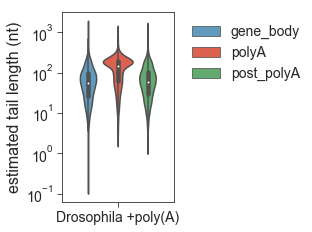

In [34]:
# SUPPLEMENTAL FIGURE S4B - S2 (with polyA polymerase) tail length estimates

# Import results from nanopolish poly(A) estimator

# S2 +poly(A) 
S2_1a_nano = pd.read_csv('/path/to/S2_1a.polyA_estimates.tsv', sep="\t", low_memory=False)
S2_1b_nano = pd.read_csv('/path/to/S2_1b.polyA_estimates.tsv', sep="\t", low_memory=False)
S2_2_nano = pd.read_csv('/path/to/S2_2.polyA_estimates.tsv', sep="\t", low_memory=False)
S2_3_nano = pd.read_csv('/path/to/S2_3.polyA_estimates.tsv', sep="\t", low_memory=False)

# concatenate samples
S2_wiA_nano = pd.concat([S2_1a_nano,S2_1b_nano,S2_2_nano,S2_3_nano]).reset_index(drop=True)

# Select only reads that passed the QC filter + remove reads when polya_length is equal to 0
S2_wiA_pass_df = S2_wiA_nano[(S2_wiA_nano['qc_tag'] == 'PASS') & (S2_wiA_nano['polya_length'] != 0.0)].reset_index(drop=True)

# Merge with nanopolish polyA estimator results
S2_read_ends_stats = pd.read_table('/path/to/S2_read_end_stats.txt')  
S2_read_ends_stats.columns = ['readname','end_feature']
S2_wiA_features_df = S2_wiA_pass_df.merge(S2_read_ends_stats, on='readname', how='inner')

# Add a category for poly(A) site vs. gene body
S2_wiA_features_df['new_feature'] = 'non_applicable'
S2_wiA_features_df.loc[S2_wiA_features_df['end_feature'] == 'polyA','new_feature'] = 'polyA'
S2_wiA_features_df.loc[S2_wiA_features_df['end_feature'].isin(['splice_site','exon','intron']), 'new_feature'] = 'gene_body'
S2_wiA_features_df.loc[S2_wiA_features_df['end_feature'] == 'post_polyA','new_feature'] = 'post_polyA'

# label and combine samples
S2_wiA_features_df['sample_type'] = 'Drosophila +poly(A)'
drosophila_samples_df = pd.concat([S2_wiA_features_df]).reset_index(drop=True)
drosophila_samples_df['log10_polya_length'] = np.log10(drosophila_samples_df['polya_length'])

# Plot tail distribution based on read end features
fig, ax = plt.subplots(figsize=(2,3.5))

# Select features of interest only
drosophila_samples_df_forPlot = drosophila_samples_df[drosophila_samples_df['new_feature'] != 'non_applicable']

sns.violinplot(x='sample_type', y='log10_polya_length', data=drosophila_samples_df_forPlot, hue='new_feature',
           hue_order=['gene_body','polyA','post_polyA'],
           palette=[sns.color_palette("Blues")[3],sns.color_palette("Reds")[3],sns.color_palette("Greens")[3]])

y_labels = ["$\mathregular{10^{-1}}$","$\mathregular{10^{0}}$","$\mathregular{10^{1}}$","$\mathregular{10^{2}}$","$\mathregular{10^{3}}$"]
plt.yticks([-1,0,1,2,3], y_labels)

plt.ylabel("estimated tail length (nt)", fontsize=16)
plt.xlabel("")

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False, fontsize=14)

plt.savefig('/path/to/Supplemental_Figure_4B_drosophila_tail_lengths_estimates_violinPlot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [30]:
samples = ['Drosophila +poly(A)']
names = ['gene_body','post_polyA','polyA']
df = drosophila_samples_df.copy()

stats_list = []

for sample in samples:
    for i in range(0,len(names)-1):
        for j in range(i+1,len(names)):
        
            t, p = ttest_ind(df[(df['new_feature']==names[i]) & (df['sample_type']==sample)]['log10_polya_length'], df[(df['new_feature']==names[j]) & (df['sample_type']==sample)]['log10_polya_length'], nan_policy='omit', equal_var=False)
            stats_list.append([sample, names[i], names[j], t, p])


Ttest_stats_df = pd.DataFrame(stats_list)
Ttest_stats_df.columns = ['sample', 'name_1', 'name_2', 'T value', 'p-value']

Ttest_stats_df       

,sample,name_1,name_2,T value,p-value
0,Drosophila +poly(A),gene_body,post_polyA,-12.266498,1.612814e-34
1,Drosophila +poly(A),gene_body,polyA,-114.955926,0.000000e+00
2,Drosophila +poly(A),post_polyA,polyA,-80.153548,0.000000e+00


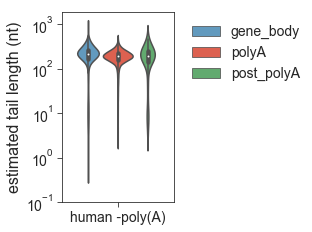

In [33]:
# SUPPLEMENTAL FIGURE S4C - K562 (without polyA polymerase) tail length estimates

# Import results from nanopolish poly(A) estimator (ran on O2)

# K562 -poly(A) 
K562_notailing_nano = pd.read_csv('/path/to/K562_no_tailing.polyA_estimates.tsv', sep='\t', low_memory=False)

# Select only reads that passed the QC filter + remove reads when polya_length is equal to 0 because causes problems with log10 (only 1 read)
K562_notailing_pass_df = K562_notailing_nano[(K562_notailing_nano['qc_tag'] == 'PASS') & (K562_notailing_nano['polya_length'] != 0.0)].reset_index(drop=True)

# Merge with nanopolish polyA estimator results
HL13_read_ends_stats = pd.read_table('/Users/hldrexler/Dropbox/Harvard/ChurchmanLab/NanoporePaper/Revisions/Datasets/nanoCOP/read_ends/HL13_read_end_stats.txt')  
HL13_read_ends_stats.columns = ['readname','end_feature']
K562_notailing_features_df = K562_notailing_pass_df.merge(HL13_read_ends_stats, on='readname', how='inner')

# Add a category for poly(A) site vs. gene body
K562_notailing_features_df['new_feature'] = 'non_applicable'
K562_notailing_features_df.loc[K562_notailing_features_df['end_feature'] == 'polyA','new_feature'] = 'polyA'
K562_notailing_features_df.loc[K562_notailing_features_df['end_feature'].isin(['splice_site','exon','intron']), 'new_feature'] = 'gene_body'
K562_notailing_features_df.loc[K562_notailing_features_df['end_feature'] == 'post_polyA','new_feature'] = 'post_polyA'

# label and combine samples
K562_notailing_features_df['sample_type'] = 'human -poly(A)'
human_samples_df = pd.concat([K562_notailing_features_df]).reset_index(drop=True)
human_samples_df['log10_polya_length'] = np.log10(human_samples_df['polya_length'])

# Plot tail distribution based on read end features
fig, ax = plt.subplots(figsize=(2,3.5))

# Select features of interest only
human_samples_df_forPlot = human_samples_df[human_samples_df['new_feature'] != 'non_applicable']

sns.violinplot(x='sample_type', y='log10_polya_length', data=human_samples_df_forPlot, hue='new_feature',
           hue_order=['gene_body','polyA','post_polyA'],
           palette=[sns.color_palette("Blues")[3],sns.color_palette("Reds")[3],sns.color_palette("Greens")[3]])

y_labels = ["$\mathregular{10^{-1}}$","$\mathregular{10^{0}}$","$\mathregular{10^{1}}$","$\mathregular{10^{2}}$","$\mathregular{10^{3}}$"]
plt.yticks([-1,0,1,2,3], y_labels)

plt.ylabel("estimated tail length (nt)", fontsize=16)
plt.xlabel("")

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False, fontsize=14)

plt.savefig('/path/to/Supplemental_Figure_4C_human_notailing_tail_lengths_estimates_violinPlot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [32]:
samples = ['human -poly(A)']
names = ['gene_body','post_polyA','polyA']
df = human_samples_df.copy()

stats_list = []

for sample in samples:
    for i in range(0,len(names)-1):
        for j in range(i+1,len(names)):
        
            t, p = ttest_ind(df[(df['new_feature']==names[i]) & (df['sample_type']==sample)]['log10_polya_length'], df[(df['new_feature']==names[j]) & (df['sample_type']==sample)]['log10_polya_length'], nan_policy='omit', equal_var=False)
            stats_list.append([sample, names[i], names[j], t, p])


Ttest_stats_df = pd.DataFrame(stats_list)
Ttest_stats_df.columns = ['sample', 'name_1', 'name_2', 'T value', 'p-value']

Ttest_stats_df       

,sample,name_1,name_2,T value,p-value
0,human -poly(A),gene_body,post_polyA,3.183156,1.583336e-03
1,human -poly(A),gene_body,polyA,-10.980238,6.718962e-28
2,human -poly(A),post_polyA,polyA,-5.199647,3.447175e-07


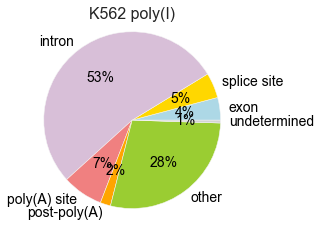

In [6]:
# SUPPLEMENTAL FIGURE S4D - K562 (with polyI polymerase)  pie chart

# read in files for making read end pie charts
K562_4_read_ends_df = pd.read_table('/path/to/K562_4_read_ends.txt')  
K562_4_read_ends_stats = pd.read_table('/path/to/K562_4_read_end_stats.txt')  

K562_5a_read_ends_df = pd.read_table('/path/to/K562_5a_read_ends.txt')  
K562_5a_read_ends_stats = pd.read_table('/path/to/K562_5a_read_end_stats.txt')  

K562_5b_read_ends_df = pd.read_table('/path/to/K562_5b_read_ends.txt')  
K562_5b_read_ends_stats = pd.read_table('/path/to/K562_5b_read_end_stats.txt')  

K562_polyI_read_ends_df = pd.concat([K562_4_read_ends_df,K562_5a_read_ends_df,K562_5b_read_ends_df],axis=0)
K562_polyI_read_ends = pybedtools.BedTool.from_dataframe(K562_polyI_read_ends_df)
K562_polyI_read_ends = K562_polyI_read_ends.saveas()

K562_polyI_read_ends_stats = pd.concat([K562_4_read_ends_stats,K562_5a_read_ends_stats,K562_5b_read_ends_stats],axis=0)

# make dataframe for pie chart
K562_polyI_pie_chart_df = get_pie_chart_df(K562_polyI_read_ends_stats, K562_polyI_read_ends)

# plot pie chart
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(3.5,3.5))

col_list = ['lightblue', 'gold', 'thistle', 'lightcoral', 'orange', 'yellowgreen', 'lightgray']
label_list=['exon','splice site','intron','poly(A) site','post-poly(A)','other','undetermined']

wedges, texts, autotexts = ax.pie(K562_polyI_pie_chart_df, labels=label_list, colors=col_list, autopct='%1.0f%%')
ax.axis('equal')    # Equal aspect ratio ensures that pie is drawn as a circle
ax.set_title('K562 poly(I)', fontsize=16)

for text in texts:
    text.set_color('black')
    text.set_fontsize(14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(14)

for w in wedges:
    w.set_linewidth(0.5)
    w.set_edgecolor('whitesmoke')

plt.savefig('/path/to/Supplemental_Figure_4D_K562_polyI_3primeEnd_pie_chart.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')
    
#plt.tight_layout()
plt.show()


In [7]:
### Statistics comparing alignment to poly(A) sites between polyA and polyI tailing

# read in files for making read end pie charts
K562_read_ends_df = pd.read_table('/path/to/K562_read_ends.txt')  
K562_read_ends = pybedtools.BedTool.from_dataframe(K562_read_ends_df)
K562_read_ends = K562_read_ends.saveas()
K562_read_ends_stats = pd.read_table('/path/to/K562_read_end_stats.txt')  

# make dataframe for pie chart
K562_pie_chart_df = get_pie_chart_df(K562_read_ends_stats, K562_read_ends)

# get values for Fisher exact test and Chi squared test
polyA_gene = np.sum(K562_pie_chart_df.loc[['exon','intron','splice_site']]['count'])
polyA_nogene = np.sum(K562_pie_chart_df['count'])-np.sum(K562_pie_chart_df.loc[['exon','intron','splice_site']]['count'])
polyI_gene = np.sum(K562_polyI_pie_chart_df.loc[['exon','intron','splice_site']]['count'])
polyI_nogene = np.sum(K562_polyI_pie_chart_df['count'])-np.sum(K562_polyI_pie_chart_df.loc[['exon','intron','splice_site']]['count'])

#np.array([[plus_A, plus_noA], [minus_A, minus_noA]])

oddsratio, pvalue = stats.fisher_exact([[polyA_gene, polyA_nogene], [polyI_gene, polyI_nogene]])
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("Fisher exact p-value: <2.2e-16")

if (pvalue>0):
    print("Fisher exact p-value: "+str(pvalue))
      

g, pvalue, dof, expctd = chi2_contingency(np.array([[polyA_gene, polyA_nogene], [polyI_gene, polyI_nogene]]))
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("chi-square p-value: <2.2e-16")

if (pvalue>0):
    print("chi-square p-value: "+str(pvalue))


Fisher exact p-value: <2.2e-16
chi-square p-value: <2.2e-16


In [3]:
# SUPPLEMENTAL FIGURE S4E - K562 poly(A) vs. poly(I) tailing correlation plot

# get reads per gene for ONT sequencing datasets
# upload gene information as a BedTool for parsing
hg38_genes_df = pd.read_csv('/path/to/annotation_files/NCBI_RefSeq_hg38_genes_parsed.bed',header=None, sep='\t')
hg38_genes_df = hg38_genes_df.drop([6,7,8,9,10,11], axis=1) # drop irrelevant columns from dataframe
hg38_genes_df.columns = ['chrom','start','end','transcript','gene_length','strand']
hg38_genes_df['gene_length'] = hg38_genes_df['end']-hg38_genes_df['start']
hg38_genes_df['transcript'] = hg38_genes_df.apply(lambda row: row['transcript'].split('.')[0], axis=1)
hg38_genes_df = hg38_genes_df.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True)

# get list of gene names for all transcripts
hg38_names_df = pd.read_csv('/path/to/annotation_files/hg38_UCSC_refGene_names.txt', header=None, sep='\t')
hg38_names_df.columns = ['gene','transcript']

hg38_genes_names_merge = pd.merge(hg38_genes_df, hg38_names_df, on=['transcript'], how='left')
hg38_genes_names_merge['gene'] = hg38_genes_names_merge.apply(lambda row: name_missing_genes(row) , axis=1)
hg38_genes_names_merge = hg38_genes_names_merge.sort_values(by='gene_length', ascending=False).reset_index(drop=True)
hg38_genes_names_merge = hg38_genes_names_merge.drop_duplicates(subset=['gene'], keep='first').reset_index(drop=True)

hg38_genes_names_merge = hg38_genes_names_merge.sort_values(by=['chrom','start','end'], ascending=True).reset_index(drop=True)
#genes_names_merge['chrom'] = 'chr'+genes_names_merge['chrom']

# create a bed file for all unique genes
hg38_genes_bed = BedTool.from_dataframe(hg38_genes_names_merge)



In [4]:
# get K562 ONT coverage information for both replicates
K562_polyA_bamFile = pybedtools.BedTool('/path/to/all_K562_polyA_hg38_minimap2_uniq_sort.bam') # merged BAM files from replicates 1, 2, 3
K562_polyI_bamFile = pybedtools.BedTool('/path/to/all_K562_polyI_hg38_minimap2_uniq_sort.bam') # merged BAM files from replicates 4, 5a, 5b

# get number of reads that overlap each gene feature
K562_polyA_counts_df = get_counts_df(K562_polyA_bamFile, hg38_genes_bed)
K562_polyI_counts_df = get_counts_df(K562_polyI_bamFile, hg38_genes_bed)

# get total number of datapoints for each sample
K562_polyA_N = int(np.sum(K562_polyA_counts_df[K562_polyA_counts_df['counts']!=0.2]['counts']))
K562_polyI_N = int(np.sum(K562_polyI_counts_df[K562_polyI_counts_df['counts']!=0.2]['counts']))


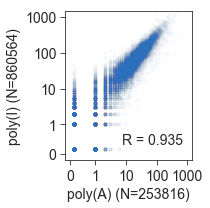

In [32]:
# prepare a plot with correlations between ONT replicate datasets

# make a correlation plot for all replicate samples
fig, ax = plt.subplots(figsize=(3,3))

# plot for rep 1 vs. rep 3
merge = pd.merge(K562_polyA_counts_df,K562_polyI_counts_df,on=['gene'],how="inner")
A=np.log10(merge['counts_x'])
B=np.log10(merge['counts_y'])

ax = sns.regplot(x=A, y=B, scatter=True, color=sns.xkcd_rgb["medium blue"], marker=".", 
                 scatter_kws={'alpha':0.01}, fit_reg=False)
ax.set_xlabel("poly(A) (N="+str(K562_polyA_N)+")",fontsize=14)
ax.set_ylabel("poly(I) (N="+str(K562_polyI_N)+")",fontsize=14)
pcor = np.corrcoef(A, B)[0, 1]
#ax.text(-0.8,2.45,"R = "+str(round(pcor,3)),horizontalalignment='left',verticalalignment='bottom',fontsize=14)
ax.text(2.85,-0.25,"R = "+str(round(pcor,3)),horizontalalignment='right',verticalalignment='top',fontsize=14)


plt.xlim(-1,3.15)
plt.ylim(-1,3.15)

x_labels = ["0","1","10","100","1000"]
plt.xticks([np.log10(0.15),0,1,2,3], x_labels, fontsize=14)

y_labels = ["0","1","10","100","1000"]
plt.yticks([np.log10(0.15),0,1,2,3], y_labels, fontsize=14)


ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.savefig('/path/to/Supplemental_Figure_4E_K562_polyA_polyI_correlation_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


In [ ]:
## Supplementary Figure 4F

In [48]:
# Analyze alignment of 3' ends
polyA_bamFile = pybedtools.BedTool('/path/to/ERCC-00048_polyA_minimap2_uniq_sort.bam')
polyA_read_ends = get_read_end_bedtool(polyA_bamFile)
polyA_read_ends_df = polyA_read_ends.to_dataframe()

polyI_bamFile = pybedtools.BedTool('/path/to/ERCC-00048_polyI_minimap2_uniq_sort.bam')
polyI_read_ends = get_read_end_bedtool(polyI_bamFile)
polyI_read_ends_df = polyI_read_ends.to_dataframe()

# get RNA 3' end positions relative to the end of the ERCC transcript
relative_read_end_positions_polyA = get_single_ERCC_read_ends('ERCC00048',969,polyA_read_ends_df)
relative_read_end_positions_polyI = get_single_ERCC_read_ends('ERCC00048',969,polyI_read_ends_df)


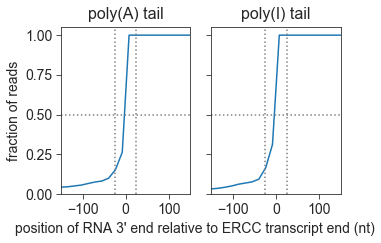

In [162]:
# plot frequency of read ends within 500 nt of polyA site of ERCC-00048

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(5,3), sharex='col', sharey='row')

sns.distplot(relative_read_end_positions_polyA, hist=False, kde_kws=dict(cumulative=True), bins=100, ax=ax[0])
ax[0].set_xlim(-150,150)
ax[0].set_ylabel("fraction of reads",fontsize=14)
ax[0].tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

sns.distplot(relative_read_end_positions_polyI, hist=False, kde_kws=dict(cumulative=True), bins=100, ax=ax[1])
ax[1].set_xlim(-150,150)
ax[1].tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)


ax[0].text(0.55,1.10,"poly(A) tail", ha='center', fontsize=16)
ax[1].text(0.55,1.10,"poly(I) tail", ha='center', fontsize=16)
fig.text(0.55, -0.025, "position of RNA 3' end relative to ERCC transcript end (nt)", ha='center', fontsize=14)


plt.tight_layout()

#plt.axhline(y=0.5, color='black', linestyle=":")
ax[0].axvline(x=-25, color='gray', linestyle=":")
ax[0].axvline(x=25, color='gray', linestyle=":")
ax[1].axvline(x=-25, color='gray', linestyle=":")
ax[1].axvline(x=25, color='gray', linestyle=":")

ax[0].axhline(y=0.5, color='gray', linestyle=":")
ax[1].axhline(y=0.5, color='gray', linestyle=":")


plt.savefig('/path/to/Supplemental_Figure_4F_polyA_polyI_ERCC_3primeEnd_cdf_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()
    

In [61]:
window = 25

tail_type = 'polyA'
read_ends = relative_read_end_positions_polyA
percent = float(sum((i >= -1*window) & (i <= window) for i in read_ends))/float(len(read_ends))*100

print(tail_type+": "+str(round(percent,2)))
  
    
tail_type = 'polyI'
read_ends = relative_read_end_positions_polyI
percent = float(sum((i >= -1*window) & (i <= window) for i in read_ends))/float(len(read_ends))*100

print(tail_type+": "+str(round(percent,2)))



polyA: 85.52
polyI: 85.14


In [ ]:

## Supplementary Figure 4G

In [33]:
# upload annotation files for analysis
hg38_df = pd.read_table('/path/to/annotation_files/NCBI_RefSeq_hg38_merge_parsed_sortByNameCoord.bed',header=None)
hg38_df.columns = ['chrom','start', 'end','gene','feature','strand']

# get junction information from introns
overlap = 100
hg38_intron_info = get_intron_info(hg38_df, overlap)


In [35]:
# upload alignment files
K562_1_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_1_hg38_minimap2_uniq_sort.bam')
K562_2_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_2_hg38_minimap2_uniq_sort.bam')
K562_3_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_3_hg38_minimap2_uniq_sort.bam')
K562_4_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_4_hg38_minimap2_uniq_sort.bam')
K562_5a_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_5a_hg38_minimap2_uniq_sort.bam')
K562_5b_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_5b_hg38_minimap2_uniq_sort.bam')

# get alignment and intron junction intersections
K562_1_intersect_df = get_intersect_df(K562_1_bamFile, hg38_intron_info)
K562_2_intersect_df = get_intersect_df(K562_2_bamFile, hg38_intron_info)
K562_3_intersect_df = get_intersect_df(K562_3_bamFile, hg38_intron_info)
K562_4_intersect_df = get_intersect_df(K562_4_bamFile, hg38_intron_info)
K562_5a_intersect_df = get_intersect_df(K562_5a_bamFile, hg38_intron_info)
K562_5b_intersect_df = get_intersect_df(K562_5b_bamFile, hg38_intron_info)

# get dataframe with distance from junction information
K562_1_distance_df = get_distance_df(K562_1_intersect_df)
K562_2_distance_df = get_distance_df(K562_2_intersect_df)
K562_3_distance_df = get_distance_df(K562_3_intersect_df)
K562_4_distance_df = get_distance_df(K562_4_intersect_df)
K562_5a_distance_df = get_distance_df(K562_5a_intersect_df)
K562_5b_distance_df = get_distance_df(K562_5b_intersect_df)

K562_distance_df = pd.concat([K562_1_distance_df, K562_2_distance_df, K562_3_distance_df, K562_4_distance_df, K562_5a_distance_df, K562_5b_distance_df])


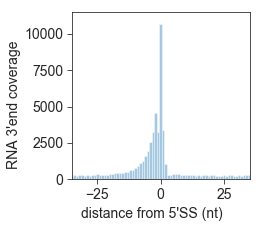

In [48]:
# Compare read end alignments around splice sites
# plot frequency of read ends (RNA 3' end) within 100 nt of the intron 5'SS

distance_df = K562_distance_df

intron_5SS_read_end = distance_df.loc[(distance_df['feature_name']=="intron_5SS") & (distance_df['read_pos']=="read_end")]['distance']

fig, ax = plt.subplots(figsize=(3.5,3))

sns.distplot(intron_5SS_read_end, kde=False, bins=200)
ax.set_xlim(-35,35)
ax.set_ylim(0,11500)
ax.tick_params("both",labelsize=14)
#ax.set_title('5\' splice site',fontsize=16)
ax.set_xlabel("",fontsize=16)
ax.set_ylabel("",fontsize=16)
ax.set_xticks([-25,0,25])
#ax.set_yticks([0,1000,2000,3000,4000,2500,3000])

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

fig.text(0.55, -0.025, "distance from 5'SS (nt)", ha='center', fontsize=14)
fig.text(-.025, 0.5, "RNA 3'end coverage", va='center', rotation='vertical', fontsize=14)

plt.tight_layout()

plt.savefig('/path/to/Supplemental_Figure_4G_K562_wiPolyI_read_end_coverage_at_splice_sites.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

